# Baseline Simple ConvNet — Rubens vs Picasso

In deze opdracht train ik eerst een **simpel convolutioneel netwerk (ConvNet)** als baseline.

**Waarom Google Colab?** Op mijn lokale pc kan ik geen GPU gebruiken, waardoor training te traag wordt. Daarom gebruik ik **Google Colab met GPU** voor dit baseline ConvNet.

**Dataset upload**: Ik heb de map `datasets/` (die lokaal aangemaakt werd met splits en sampling) en geüpload naar mijn Google Drive.

Deze notebook:
1) controleert GPU
2) verbindt met de drive om de datasets te halen
3) laadt de dataset (startend met `undersampled`)
4) traint een baseline ConvNet
5) evalueert op de testset
6) bewaart en downloadt het model.


## 0. GPU instellen in Colab

Zet eerst GPU aan via:
**Runtime → Change runtime type → Hardware accelerator → GPU → Save**

Run daarna de cel hieronder om te verifiëren dat TensorFlow de GPU ziet.

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPU devices:", gpus)

if not gpus:
    print("\nGeen GPU gevonden. Controleer: Runtime → Change runtime type → GPU")
else:
    print("\nGPU is actief. We kunnen trainen met GPU-acceleratie.")


GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU is actief. We kunnen trainen met GPU-acceleratie.


## 1. Verbinden met Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Controleer de mapstructuur

We controleren of `rubens_picasso/` en de samplingvarianten aanwezig zijn.

In [2]:
from pathlib import Path

base = Path("/content/drive/MyDrive/datasets/rubens_picasso")
assert base.exists(), f"Verwachte map ontbreekt: {base}"

print("Gevonden:", base)
print("Inhoud:", [p.name for p in base.iterdir() if p.is_dir()])


Gevonden: /content/drive/MyDrive/datasets/rubens_picasso
Inhoud: ['undersampled', 'oversampled', 'imbalanced']


## 2. Dataset kiezen (start met `undersampled`)

We starten met de **undersampled** variant omdat die gebalanceerd is (zelfde aantal Rubens en Picasso).
Later kan je dezelfde code hergebruiken voor `imbalanced` of `oversampled`.

In [3]:
from pathlib import Path

# Datasetlocatie op Google Drive
DATASET_BASE = Path("/content/drive/MyDrive/datasets/rubens_picasso")

# Controleer of de map bestaat
assert DATASET_BASE.exists(), f"Verwachte map ontbreekt: {DATASET_BASE}"

print("Gevonden:", DATASET_BASE)
print("Inhoud:", [p.name for p in DATASET_BASE.iterdir() if p.is_dir()])

# Kies samplingvariant : we beginnen dus met undersampled
VARIANT = "undersampled"  # "undersampled", "oversampled", "imbalanced"

# Train / val / test mappen
TRAIN_DIR = DATASET_BASE / VARIANT / "train"
VAL_DIR   = DATASET_BASE / VARIANT / "val"
TEST_DIR  = DATASET_BASE / VARIANT / "test"

# Extra safety checks
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    assert d.exists(), f"Verwachte map ontbreekt: {d}"

print("\nTrain dir:", TRAIN_DIR)
print("Val dir  :", VAL_DIR)
print("Test dir :", TEST_DIR)



Gevonden: /content/drive/MyDrive/datasets/rubens_picasso
Inhoud: ['undersampled', 'oversampled', 'imbalanced']

Train dir: /content/drive/MyDrive/datasets/rubens_picasso/undersampled/train
Val dir  : /content/drive/MyDrive/datasets/rubens_picasso/undersampled/val
Test dir : /content/drive/MyDrive/datasets/rubens_picasso/undersampled/test


## 3. Datasets laden met `image_dataset_from_directory`

Omdat dit een **binaire classificatie** is (Rubens vs Picasso), gebruiken we:
- `label_mode='binary'` → labels zijn 0/1
- outputlaag `Dense(1, sigmoid)`
- loss `binary_crossentropy`

### Keuze van input image size

Op basis van de datasetanalyse liggen de mediane afbeeldingsafmetingen rond
520×550 pixels, met 75% van de afbeeldingen kleiner dan ongeveer 800×826 pixels.
Het is echter niet praktisch om met deze resoluties te trainen, omdat CNN’s een
vaste inputgrootte vereisen en hoge resoluties de trainingskost sterk verhogen.

Daarom kiezen we voor een vaste input size van **224×224** pixels. Deze grootte
biedt een goede balans tussen detailbehoud en rekenefficiëntie en is bovendien
de standaard inputgrootte voor VGG16, wat latere transfer learning en fine-tuning
vereenvoudigt. Voor de baseline ConvNet gebruiken we dezelfde input size om
consistente vergelijkingen mogelijk te maken.


In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)   # 224 is standaard voor VGG16 later
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

print("Class names (alphabetisch):", train_ds.class_names)
print("→ label 0 =", train_ds.class_names[0])
print("→ label 1 =", train_ds.class_names[1])


Found 954 files belonging to 2 classes.
Found 204 files belonging to 2 classes.
Found 206 files belonging to 2 classes.
Class names (alphabetisch): ['Picasso', 'Rubens']
→ label 0 = Picasso
→ label 1 = Rubens


### Controle van geladen datasets

Bij het inladen van de undersampled dataset werden 954 afbeeldingen gevonden
voor training, 204 voor validatie en 206 voor testing, telkens verdeeld over
twee klassen. Deze aantallen komen overeen met een hold-out split van ongeveer
70/15/15 op een gebalanceerde dataset (682 afbeeldingen per klasse).

De klassen worden door Keras alfabetisch gelabeld als:
- Picasso → label 0
- Rubens → label 1

Dit sluit correct aan bij het gebruik van een sigmoid-outputlaag en de
binary_crossentropy lossfunctie.


### 3.1 Performance-optimalisatie (`cache` + `prefetch`)

Dit maakt training vaak sneller op Colab. Het verandert de inhoud niet, alleen de throughput.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("cache+prefetch ingesteld.")


cache+prefetch ingesteld.


## 4. Baseline Simple ConvNet

We bouwen een eenvoudig ConvNet met Conv2D + MaxPooling blocks en een sigmoid output.
We normaliseren de pixelwaarden met `Rescaling(1./255)`.

Dit is een baseline. Later voegen we data augmentation toe en gebruiken we transfer learning (VGG16).

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=IMG_SIZE + (3,))

# Rescaling: zet pixelwaarden van [0..255] naar [0..1]
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,097 (3.83 MB)

 Trainable params: 1,004,097 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training

We trainen met:
- `EarlyStopping`: stopt als de validatie niet meer verbetert
- `ModelCheckpoint`: bewaart het beste model

💾 Het model wordt opgeslagen als `.keras` (aanbevolen formaat).

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class LivePlotCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.train_loss, self.val_loss = [], []
        self.train_acc, self.val_acc = [], []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        self.epochs.append(epoch + 1)
        self.train_loss.append(logs.get("loss"))
        self.val_loss.append(logs.get("val_loss"))
        self.train_acc.append(logs.get("accuracy"))
        self.val_acc.append(logs.get("val_accuracy"))

        # 1 plot vervangen door de volgende (netter in Colab)
        clear_output(wait=True)

        plt.figure(figsize=(12,4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_acc, label="train acc")
        plt.plot(self.epochs, self.val_acc, label="val acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_loss, label="train loss")
        plt.plot(self.epochs, self.val_loss, label="val loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.show()


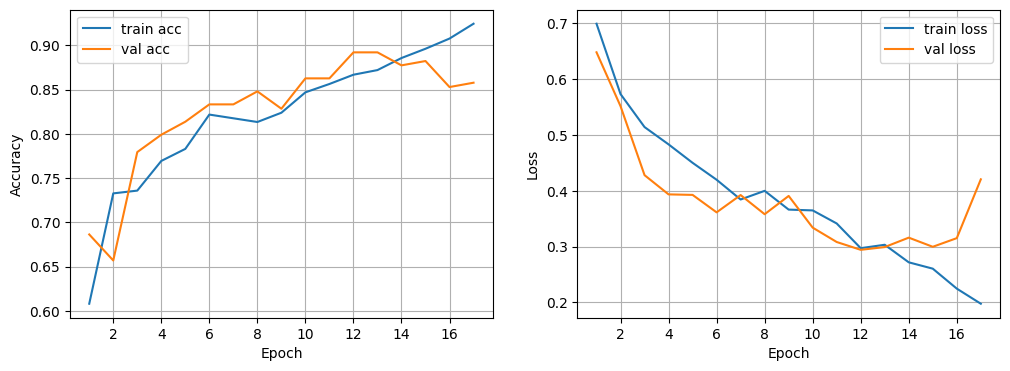

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9330 - loss: 0.1900 - val_accuracy: 0.8578 - val_loss: 0.4204
Training klaar. Beste model opgeslagen naar: /content/models/baseline_convnet_undersampled_rubens_picasso.keras


In [10]:
from tensorflow import keras
from pathlib import Path

Path("/content/models").mkdir(exist_ok=True)

MODEL_PATH = f"/content/models/baseline_convnet_{VARIANT}_rubens_picasso.keras"

live_plot = LivePlotCallback()

callbacks = [
    live_plot,  # custom callback (real-time plotting)
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

print("Training klaar. Beste model opgeslagen naar:", MODEL_PATH)


### Analyse van trainings- en validatiecurves

De trainingsaccuracy stijgt gestaag tot ongeveer 93%, terwijl de validatieaccuracy
na een initiële stijging rond epoch 12 begint te stagneren en licht daalt. Een
gelijkaardig patroon is zichtbaar in de loss-curves: de training loss blijft dalen,
terwijl de validatie loss na ongeveer epoch 12 opnieuw stijgt. Dit wijst op
***overfitting***: het model leert steeds beter de trainingsdata, maar generaliseert
niet verder naar ongeziene data.

Early stopping selecteert automatisch het beste model vóór het optreden van
overfitting. Deze resultaten vormen een duidelijke motivatie voor het toepassen
van data augmentation en transfer learning in de volgende experimenten.


## 6. Evaluatie op de testset

De testset werd apart gehouden en wordt enkel gebruikt voor de finale evaluatie van deze configuratie.

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8782 - loss: 0.3506
Test loss: 0.29907822608947754
Test accuracy: 0.8883495330810547


### Evaluate versus predict

De methode `model.evaluate()` rapporteert globale prestatiemetrieken zoals
loss en accuracy over de volledige testset. Deze samenvattende evaluatie is
geschikt om modellen te vergelijken, maar biedt geen inzicht in de aard van
de gemaakte fouten. Om een confusion matrix en klasse-specifieke metrieken
zoals precision en recall te berekenen, zijn individuele voorspellingen per
sample nodig. Daarom wordt aanvullend `model.predict()` gebruikt op de testset.


## 7. Confusion matrix

Omdat je model een sigmoid output heeft (Dense(1, activation="sigmoid")), geeft model.predict() kansen terug tussen 0 en 1.

In [12]:
import numpy as np

# Voorspel kansen op testset
y_pred_prob = model.predict(test_ds)

# Zet kansen om naar klassen (0 of 1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


En nu de echte labels ophalen

In [13]:
# Echte labels verzamelen
y_true = np.concatenate([y for _, y in test_ds]).astype(int)


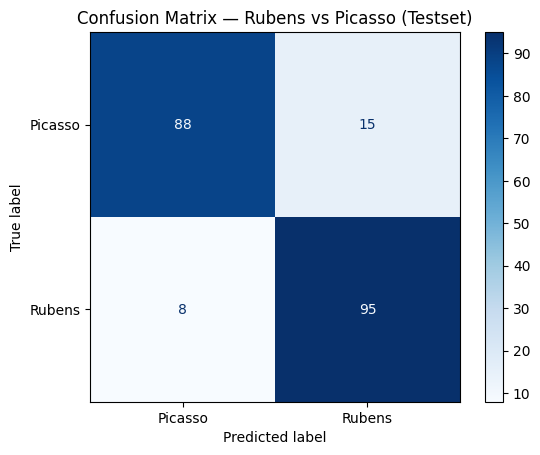

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Picasso", "Rubens"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Rubens vs Picasso (Testset)")
plt.show()


In [15]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Picasso", "Rubens"],
        digits=3
    )
)


              precision    recall  f1-score   support

     Picasso      0.917     0.854     0.884       103
      Rubens      0.864     0.922     0.892       103

    accuracy                          0.888       206
   macro avg      0.890     0.888     0.888       206
weighted avg      0.890     0.888     0.888       206



## 8. Model downloaden naar je pc

Download het opgeslagen `.keras` modelbestand zodat je het lokaal kan bewaren of later opnieuw kan laden.

In [ ]:
from google.colab import files

files.download(MODEL_PATH)


## 10. Experiment: oversampling (train-set balancing)

In deze variant trainen we **hetzelfde baseline ConvNet** op de map `oversampled/`.

- **Train**: gebalanceerd door **duplicatie** van beelden uit de minderheidsklasse.
- **Val/Test**: blijven gebaseerd op **unieke originele** afbeeldingen (geen duplicaten), zodat de evaluatie eerlijk blijft.

We bouwen het model opnieuw (zelfde architectuur) zodat de training **niet verdergaat op de gewichten** van het vorige experiment.


In [22]:
VARIANT = "oversampled"

TRAIN_DIR = DATASET_BASE / VARIANT / "train"
VAL_DIR   = DATASET_BASE / VARIANT / "val"
TEST_DIR  = DATASET_BASE / VARIANT / "test"

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    assert d.exists(), f"Verwachte map ontbreekt: {d}"

print("Train dir:", TRAIN_DIR)
print("Val dir  :", VAL_DIR)
print("Test dir :", TEST_DIR)


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds_os = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
    seed=SEED
)

val_ds_os = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

test_ds_os = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

print("Class names:", train_ds_os.class_names)

# Performance: cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds_os = train_ds_os.cache().prefetch(AUTOTUNE)
val_ds_os   = val_ds_os.cache().prefetch(AUTOTUNE)
test_ds_os  = test_ds_os.cache().prefetch(AUTOTUNE)




Train dir: /content/drive/MyDrive/datasets/rubens_picasso/oversampled/train
Val dir  : /content/drive/MyDrive/datasets/rubens_picasso/oversampled/val
Test dir : /content/drive/MyDrive/datasets/rubens_picasso/oversampled/test
Found 2140 files belonging to 2 classes.
Found 331 files belonging to 2 classes.
Found 333 files belonging to 2 classes.
Class names: ['Picasso', 'Rubens']


In [23]:
# Model opnieuw bouwen (zelfde baseline architectuur)
def build_baseline_convnet(img_size=(224,224)):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"]
    )
    return model

model_os = build_baseline_convnet(IMG_SIZE)
model_os.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        25,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,097 (3.83 MB)

 Trainable params: 1,004,097 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

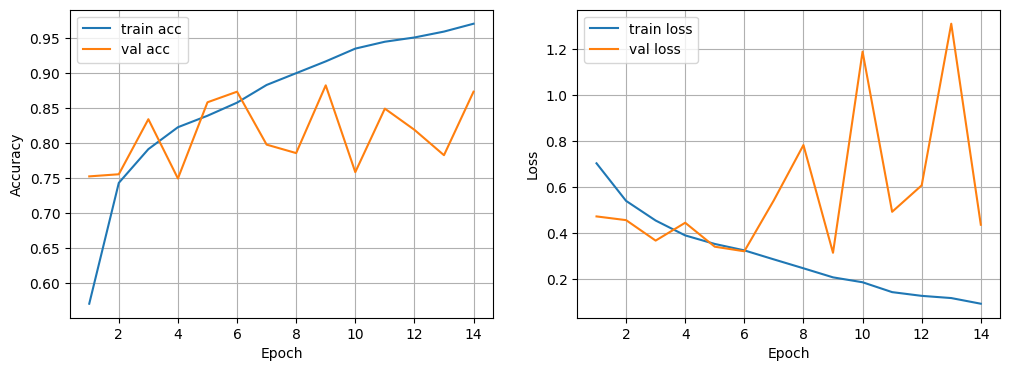

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9589 - loss: 0.1129 - val_accuracy: 0.8731 - val_loss: 0.4357
Training klaar. Beste model opgeslagen naar: /content/models/baseline_convnet_oversampled_rubens_picasso.keras


In [24]:
# Trainen + opslaan
Path("/content/models").mkdir(exist_ok=True)
MODEL_PATH_OS = f"/content/models/baseline_convnet_{VARIANT}_rubens_picasso.keras"

live_plot = LivePlotCallback()
callbacks_os = [
    live_plot,
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(MODEL_PATH_OS, save_best_only=True),
]

history_os = model_os.fit(
    train_ds_os,
    validation_data=val_ds_os,
    epochs=30,
    callbacks=callbacks_os
)

print("Training klaar. Beste model opgeslagen naar:", MODEL_PATH_OS)



In [25]:
# Evaluatie op testset
test_loss_os, test_acc_os = model_os.evaluate(test_ds_os)
print("Test loss (oversampled):", test_loss_os)
print("Test accuracy (oversampled):", test_acc_os)

11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.8496 - loss: 0.3772
Test loss (oversampled): 0.3405105471611023
Test accuracy (oversampled): 0.8678678870201111


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


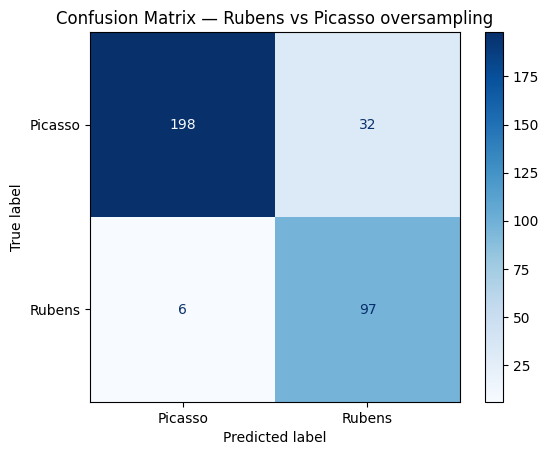

In [29]:
# Voorspel kansen op testset
y_pred_prob = model.predict(test_ds_os)

# Zet kansen om naar klassen (0 of 1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Echte labels verzamelen
y_true = np.concatenate([y for _, y in test_ds_os]).astype(int)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Picasso", "Rubens"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Rubens vs Picasso oversampling")
plt.show()



In [30]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Picasso", "Rubens"],
        digits=3
    )
)

              precision    recall  f1-score   support

     Picasso      0.971     0.861     0.912       230
      Rubens      0.752     0.942     0.836       103

    accuracy                          0.886       333
   macro avg      0.861     0.901     0.874       333
weighted avg      0.903     0.886     0.889       333



### Analyse oversampling

Bij training met oversampling zien we een sterke stijging in training accuracy
(≈96%), terwijl de validatiecurves instabiel worden en de validatie loss sterk
schommelt. Dit wijst op uitgesproken overfitting, wat te verklaren is door de
duplicatie van afbeeldingen in de trainingsset. De test accuracy (≈86.8%) en
macro F1-score (≈0.87) liggen lager dan bij de undersampled baseline.

De confusion matrix en classification report tonen dat oversampling de recall
van de minderheidsklasse (Rubens) aanzienlijk verhoogt (≈94%), maar dit gaat
ten koste van de precision en leidt tot meer foutieve Rubens-voorspellingen
voor Picasso-afbeeldingen. Oversampling introduceert dus een bias richting
de minderheidsklasse en is in deze opzet minder geschikt dan undersampling.
